In [1]:
import re
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk

nltk.download("rslp")


[nltk_data] Downloading package rslp to /home/marvin-
[nltk_data]     linux/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [2]:
def stemming(texto: str) -> str:
    stemmer = nltk.stem.RSLPStemmer()
    palavras = []
    palavras = [stemmer.stem(palavra) for palavra in texto.split()]
    return " ".join(palavras)


def remover_stop_words(texto: str, more_words: list = []) -> str:
    stopwords = nltk.corpus.stopwords.words("portuguese")
    stopwords.extend(more_words)
    stopwords.extend(
        [
            "rt",
            "http",
            "https",
            "com",
            "co",
            "org",
            "www",
            "...",
            "q",
            "d",
            "p",
            "ai",
            "pq",
            "vc",
            "nao",
            "n",
        ]
    )
    texto = " ".join(list(filter(lambda x: x not in stopwords, texto.split())))
    return texto


def formatar_texto(texto: str) -> str:
    texto = (
        re.sub(r"(http\S+)|(@\w+)", "", texto)  # remove links, usuários
        .replace(".", "")
        .replace(";", "")
        .replace("-", "")
        .replace(":", "")
        .replace(")", "")
    )

    texto = re.sub(r"(  +)", " ", texto)  # remove espaços duplos
    texto = texto.lower().strip()

    return texto


False

In [3]:
df = pd.read_csv("../data/raw/NoThemeTweets.csv").drop(
    columns=["id", "query_used"], axis=1  # remove colunas desnecessárias
)


In [4]:

df.drop_duplicates(["tweet_text"], inplace=True)  # remove textos duplicados
df["tweet_text"] = df["tweet_text"].apply(
    lambda tweet: formatar_texto(texto=tweet)
)  # formata texto do dataframe


Gostei de um vídeo @YouTube https://t.co/LGNjrDc2Qf To The Races - Lana Del Rey - Lyrics :)
gostei de um vídeo to the races lana del rey lyrics


In [5]:
df = df.assign(
    number_words=df.tweet_text.apply(lambda x: len(x.split(" "))),
)  # adiciona coluna com número de palavras
formated_df = df.drop(
    df[df.number_words < 5].index
)  # remove tweets com menos de 5 palavras

print(df.shape)
formated_df


(776753, 4)


,tweet_text,tweet_date,sentiment,number_words
1,o meu like eu já dei na época,Tue Aug 21 04:32:55 +0000 2018,Positivo,8
2,eu só queria conseguir comer alguma coisa pra ...,Tue Aug 21 04:32:37 +0000 2018,Positivo,10
3,d que lindo dia !,Tue Aug 21 04:32:33 +0000 2018,Positivo,5
4,"pq da pr jeito!!é uma ""oferta"", ha q aproveitar p",Tue Aug 21 04:32:21 +0000 2018,Positivo,10
5,"eu entendi, mas isso foi mais porque eu pensei...",Tue Aug 21 04:32:03 +0000 2018,Positivo,13
...,...,...,...,...
785809,acordar 8 horas é tão bom,Fri Oct 12 11:10:01 +0000 2018,Positivo,6
785810,"olá, mayck você já é cliente claro? caso não s...",Fri Oct 12 11:16:02 +0000 2018,Positivo,28
785811,opa tava na merda mm e fiquei logo mais feliz ...,Fri Oct 12 11:12:49 +0000 2018,Positivo,14
785812,foi como a tua lealdade,Fri Oct 12 11:11:24 +0000 2018,Positivo,5


In [6]:
print(formated_df.describe())

formated_df


        number_words
count  632562.000000
mean       14.460129
std         9.894103
min         5.000000
25%         7.000000
50%        11.000000
75%        18.000000
max        85.000000


,tweet_text,tweet_date,sentiment,number_words
1,o meu like eu já dei na época,Tue Aug 21 04:32:55 +0000 2018,Positivo,8
2,eu só queria conseguir comer alguma coisa pra ...,Tue Aug 21 04:32:37 +0000 2018,Positivo,10
3,d que lindo dia !,Tue Aug 21 04:32:33 +0000 2018,Positivo,5
4,"pq da pr jeito!!é uma ""oferta"", ha q aproveitar p",Tue Aug 21 04:32:21 +0000 2018,Positivo,10
5,"eu entendi, mas isso foi mais porque eu pensei...",Tue Aug 21 04:32:03 +0000 2018,Positivo,13
...,...,...,...,...
785809,acordar 8 horas é tão bom,Fri Oct 12 11:10:01 +0000 2018,Positivo,6
785810,"olá, mayck você já é cliente claro? caso não s...",Fri Oct 12 11:16:02 +0000 2018,Positivo,28
785811,opa tava na merda mm e fiquei logo mais feliz ...,Fri Oct 12 11:12:49 +0000 2018,Positivo,14
785812,foi como a tua lealdade,Fri Oct 12 11:11:24 +0000 2018,Positivo,5


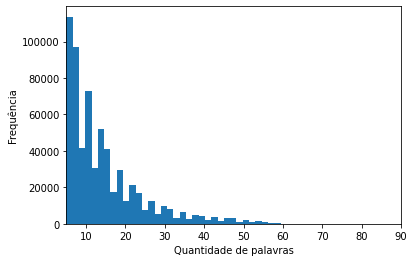

In [7]:
plt.hist(formated_df.number_words, bins=50)
plt.xlabel("Quantidade de palavras")
plt.ylabel("Frequência")
plt.xlim([5, 90])
plt.show()


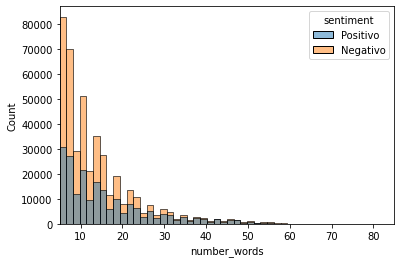

In [8]:
sns.histplot(data=formated_df, x="number_words", hue="sentiment", bins=50)
plt.xlim(5, 85)
plt.show()


In [9]:
df_positivo = formated_df.query("sentiment == 'Positivo'")
df_negativo = formated_df.query("sentiment == 'Negativo'")

positive_text = " ".join(df_positivo.tweet_text)
negative_text = " ".join(df_negativo.tweet_text)

positive_filter = remover_stop_words(positive_text)
negative_filter = remover_stop_words(negative_text)


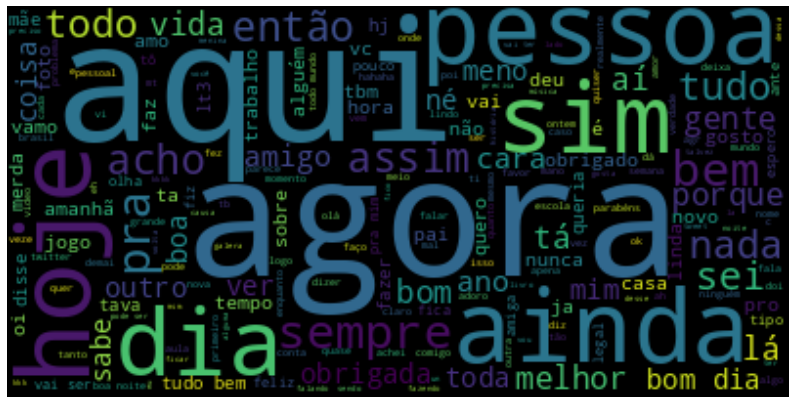

In [10]:
# Generate a word cloud image
wordcloud = WordCloud().generate(positive_filter)
plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


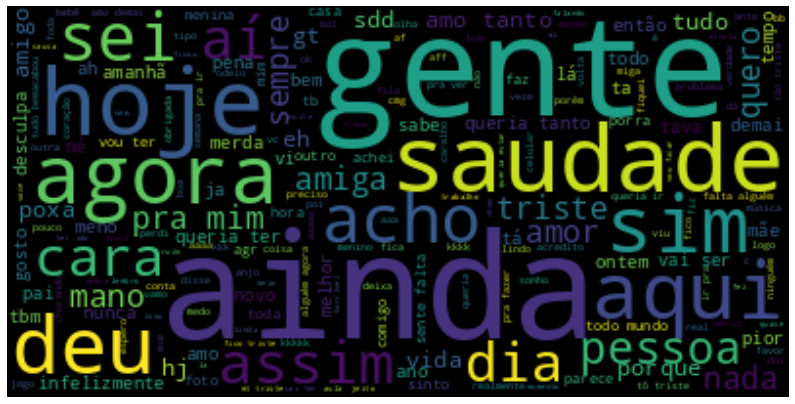

In [11]:
wordcloud = WordCloud().generate(negative_filter)
plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


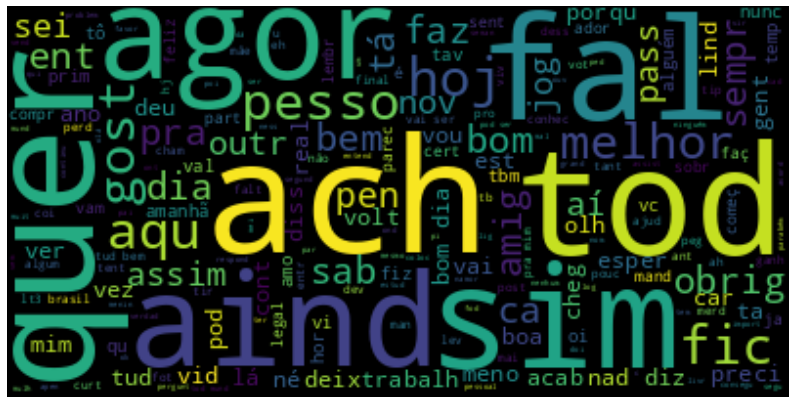

In [12]:
wordcloud = WordCloud().generate(stemming(positive_filter))
plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


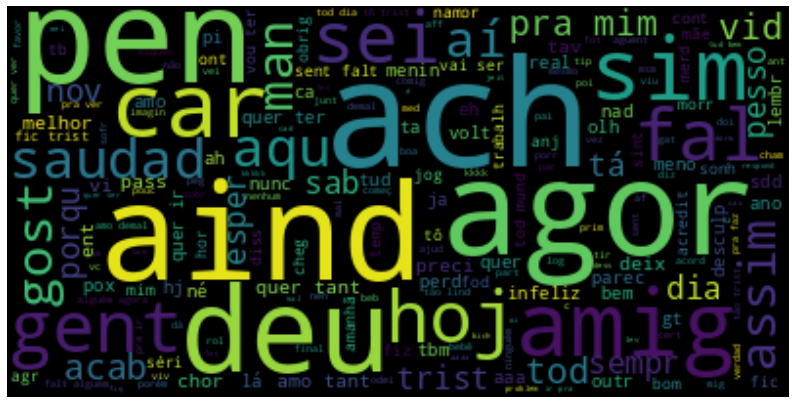

In [13]:
wordcloud = WordCloud().generate(stemming(negative_filter))
plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [ ]:
for